In [1]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which uses a recurrent structure to propagates in time.
"""

import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['export OPENBLAS_NUM_THREADS']='2'

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [2]:
################################################################
# fourier layer
################################################################

class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(12, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

################################################################
# configs
################################################################

TRAIN_PATH = 'data/ns_V1e-3_N5000_T50.mat'
TEST_PATH = 'data/ns_V1e-3_N5000_T50.mat'

ntrain = 1000
ntest = 200

modes = 12
width = 20

batch_size = 20
batch_size2 = batch_size

epochs = 10 #100 #500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'ns_fourier_2d_rnn_V10000_T20_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path

sub = 1
S = 64
T_in = 10
T = 10
step = 1

################################################################
# load data
################################################################

reader = MatReader(TRAIN_PATH)

train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

train_a = train_a.reshape(ntrain,S,S,T_in)
test_a = test_a.reshape(ntest,S,S,T_in)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

################################################################
# training and evaluation
################################################################

model = FNO2d(modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

# print(count_params(model))
# optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

myloss = LpLoss(size_average=False)
# for ep in range(epochs):
#     model.train()
#     t1 = default_timer()
#     train_l2_step = 0
#     train_l2_full = 0
#     for xx, yy in train_loader:
#         loss = 0
#         xx = xx.to(device)
#         yy = yy.to(device)

#         for t in range(0, T, step):
#             y = yy[..., t:t + step]
#             im = model(xx)
#             loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

#             if t == 0:
#                 pred = im
#             else:
#                 pred = torch.cat((pred, im), -1)

#             xx = torch.cat((xx[..., step:], im), dim=-1)

#         train_l2_step += loss.item()
#         l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
#         train_l2_full += l2_full.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     test_l2_step = 0
#     test_l2_full = 0
#     with torch.no_grad():
#         for xx, yy in test_loader:
#             loss = 0
#             xx = xx.to(device)
#             yy = yy.to(device)

#             for t in range(0, T, step):
#                 y = yy[..., t:t + step]
#                 im = model(xx)
#                 loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))

#                 if t == 0:
#                     pred = im
#                 else:
#                     pred = torch.cat((pred, im), -1)

#                 xx = torch.cat((xx[..., step:], im), dim=-1)

#             test_l2_step += loss.item()
#             test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()

#     t2 = default_timer()
#     scheduler.step()
#     print(ep, t2 - t1, train_l2_step / ntrain / (T / step), train_l2_full / ntrain, test_l2_step / ntest / (T / step),
#           test_l2_full / ntest)
# torch.save(model, path_model)



10 0.001 100 0.5


torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])
torch.Size([64, 64, 10])


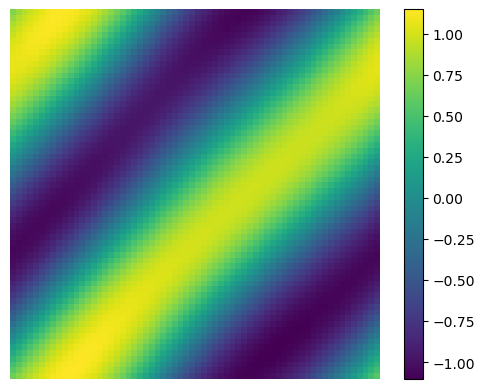

In [5]:
pred = torch.zeros(test_u.shape)
index = 0

model = torch.load('model/ns_fourier_2d_rnn_V10000_T20_N1000_ep500_m12_w20')
first_input = 0
first_output = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
total_test_l2 = 0
total_std_test_l2 = 0
mean = 0.017207859735935926
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        if index == 0:
            first_input = x.clone()
            first_output = y.clone()

        x, y = x.cuda(), y.cuda()
        out = model(x)
        # out = y_normalizer.decode(out)
        pred[index] = out
        print(pred[index].shape)

        
        test_l2 += myloss(out.view(1, -1), y.view(1,-1)[:,::10]).item()
        # print(index, test_l2)
        index = index + 1
        total_test_l2 += test_l2
        total_std_test_l2 += (test_l2-mean)**2

print(f"Average loss over all test samples is {total_test_l2/index}")
print(f"Standard deviation over all test samples is {np.sqrt(total_std_test_l2/index)}")
# scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy()})

# Input
# for i in range(10):
#     Z = first_input[0,:,:,i]
#     cp = plt.imshow(Z)
#     plt.axis('off')
#     plt.colorbar(cp) # Add a colorbar to a plot
#     plt.show()

# for i in range(10):
#     fig,ax=plt.subplots()
#     ax.set_title('Filled Contours Plot')
#     Z = first_output[0,:,:,i]
#     cp = ax.imshow(Z)
#     fig.colorbar(cp) # Add a colorbar to a plot
#     plt.show()

# print(myloss(pred[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item())

# First prediction
Z = pred[0,:,:,0]
cp = plt.imshow(Z)
plt.axis('off')
plt.colorbar(cp) # Add a colorbar to a plot
plt.show()

# First actual output
# Z = first_output[0,:,:,0]
# cp = plt.imshow(Z)
# plt.axis('off')
# plt.colorbar(cp) # Add a colorbar to a plot
# plt.show()

# Error between first prediction and first output
# Z = pred[0,:,:,0] - first_output[0,:,:,0]
# cp = plt.imshow(Z)
# plt.axis('off')
# plt.colorbar(cp) # Add a colorbar to a plot
# plt.show()

# for i in range(1,10):
#     Z = pred[0,:,:,i]
#     plt.imshow(Z)
#     plt.axis('off')
#     # fig.colorbar(cp) # Add a colorbar to a plot
#     plt.show()
#     # print(pred[0,:,:,i] == pred[0,:,:,i-1])

test_input_pred = first_input.clone()
test_input_out = first_input.clone()
test_pred = pred.clone()
test_out = pred.clone()

# Sanity check
# print(myloss(pred[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item())
# # loss_hist = np.zeros(10)
# for j in range(9):
#     for i in range(9):
#         test_input_pred[0,:,:,i] = test_input_pred[0,:,:,i+1]
#         test_input_out[0,:,:,i] = test_input_out[0,:,:,i+1]
    
#     test_input_pred[0,:,:,9] = test_pred[0,:,:,0]
#     test_input_out[0,:,:,9] = first_output[0,:,:, j]

#     with torch.no_grad():
#         test_pred[0] = model(test_input_pred.cuda())
#         test_pred_loss = myloss(test_pred[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item()
#         print(test_pred_loss)
#         # loss_hist[j+1] += test_pred_loss

#         test_out[0] = model(test_input_out.cuda())
#         test_out_loss = myloss(test_out[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item()
#         # print(test_out_loss)
    
#         # loss_diff = test_out_loss - test_pred_loss
#         # print(f"Loss difference is: {loss_diff}")
        
        
#     # fig,(ax1,ax2, ax3)=plt.subplots(1,3)
#     # Z = test_pred[0,:,:,0]
#     # cp1 = ax1.imshow(test_pred[0,:,:,0])
#     # cp2 = ax2.imshow(test_out[0,:,:,0])
#     # cp3 = ax3.imshow(first_output[0,:,:,j])
#     if j == 8:
#         cp = plt.imshow(test_pred[0,:,:,0]-first_output[0,:,:,j])
#         plt.colorbar(cp)
#         plt.axis('off')
#         plt.show()
#     cp = plt.imshow(test_pred[0,:,:,0])
#     plt.colorbar(cp)
#     plt.axis('off')
#     plt.show()
#     # plt.imshow(test_out[0,:,:,0])
#     cp = plt.imshow(first_output[0,:,:,j])
#     plt.colorbar(cp)
#     plt.axis('off')
#     # fig.colorbar(cp2) # Add a colorbar to a plot
#     plt.show()

    
# plt.plot(loss_hist, marker='o')
# plt.title("Loss vs Time-step")
# plt.ylabel("Loss (L2-norm)")
# plt.xlabel("Time-step (t)")
# plt.show()

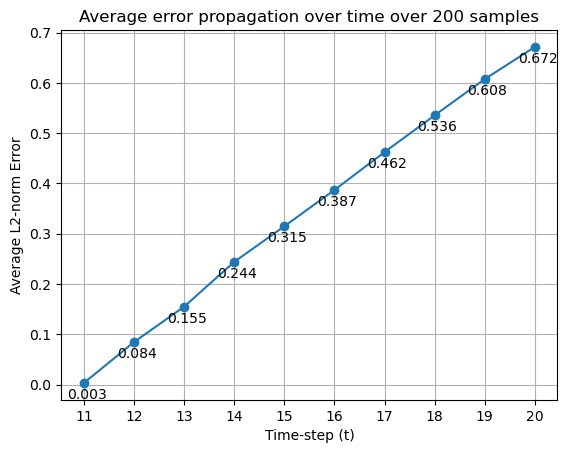

In [4]:
pred = torch.zeros(test_u.shape)
index = 0

model = torch.load('model/ns_fourier_2d_rnn_V10000_T20_N1000_ep500_m12_w20')
first_input = 0
first_output = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)

loss_hist = np.zeros(10)

with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        # if index == 0:
        #     first_input = x.clone()
        #     first_output = y.clone()

        first_input = x.clone()
        first_output = y.clone()

        test_input_pred = first_input.clone()
        
        x, y = x.cuda(), y.cuda()
        out = model(x)
        # out = y_normalizer.decode(out)
        pred[index] = out
        test_l2 += myloss(out.view(1, -1), y.view(1,-1)[:,::10]).item()

        test_pred = pred.clone()
        test_out = pred.clone()

        loss_hist[0] += test_l2

        for j in range(9):
            for i in range(9):
                test_input_pred[0,:,:,i] = test_input_pred[0,:,:,i+1]
            
            test_input_pred[0,:,:,9] = test_pred[0,:,:,0]

            with torch.no_grad():
                test_pred[0] = model(test_input_pred.cuda())
                test_pred_loss = myloss(test_pred[0].view(1, -1)[:,::10], first_output.view(1,-1)[:,::10]).item()
                loss_hist[j+1] += test_pred_loss

        # print(index, test_l2)
        index = index + 1

# scipy.io.savemat('pred/'+path+'.mat', mdict={'pred': pred.cpu().numpy()})
average_loss = loss_hist/len(pred)
fig, ax = plt.subplots()
x = np.linspace(11,20,10)
ax.plot(x, average_loss, marker='o')
ax.set_title("Average error propagation over time over 200 samples")
ax.set_ylabel("Average L2-norm Error")
ax.set_xlabel("Time-step (t)")
ax.set_xticks(x)
# add annotations for the y-values at the markers
for x, y in zip(x, average_loss):
    label = "{:.3f}".format(y)
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(2, -11.5), ha='center')

ax.grid()
plt.show()